# Initialization

In [1]:
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *
from geomloss import SamplesLoss
from skopt import gp_minimize
import torchvision
import kornia as K
import functools
from skopt.plots import plot_convergence

In [2]:
%%capture
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',20,modality='t2')
hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',20,modality='t2')

In [3]:
data_root = '/media/hdd/viscent/FLYWHEEL_DOLPHIN/D2_Plus/Hyperfine_Scans'
subject_list = os.listdir(data_root)
# Exclude hidden files
subject_list = [x for x in subject_list if not x.startswith('.')]
session_list = []
for subject in subject_list:
    for session in os.listdir(os.path.join(data_root, subject)):
        if not session.startswith('.'):
            session_list.append(os.path.join(data_root, subject, session))      
t2_file_list = []
for session in session_list:
    tmp = os.listdir(session)
    tmp = [x for x in tmp if not x.startswith('.')]
    nifti_dir = os.path.join(session, tmp[0],'nifti')
    nifti_file = os.listdir(nifti_dir)
    nifti_file = [x for x in nifti_file if x.endswith('.nii.gz') and not x.startswith('.')][0]
    t2_file_list.append(os.path.join(nifti_dir, nifti_file))


In [4]:
%%capture
model = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/unet_dhcp_t2/1600.pth')
model.eval()
model.cuda()

# Preprocessing

## Brain extraction

In [6]:
import shutil

for i,t2_file in tqdm(enumerate(t2_file_list),total=len(t2_file_list)):
    shutil.copy(t2_file, '/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_raw/%03d.nii.gz'%i)
    os.system('hd-bet -i /media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_raw/%03d.nii.gz -o /media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_brain/%03d.nii.gz'% (i,i))

  0%|          | 0/352 [00:00<?, ?it/s]


########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_raw/000.nii.gz
preprocessing...
image shape after preprocessing:  (159, 160, 159)
prediction (CNN id)...
0
1
2
3
4
running postprocessing... 
exporting segmentation...

########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
##########

## Transposing

<Figure size 1440x720 with 0 Axes>

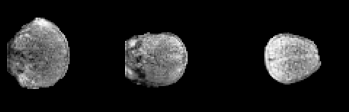

<Figure size 1440x720 with 0 Axes>

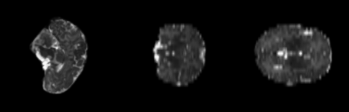

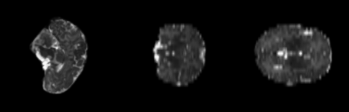

In [9]:
display_multiplanar_center(sitk.GetArrayFromImage(sitk.ReadImage('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_brain/000.nii.gz')).transpose(2,1,0))
display_multiplanar_center(iter(dhcp_test_loader).next()[0][0,0].cpu().numpy())

In [ ]:
for i in range(113):
    img = sitk.ReadImage('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_brain/%03d.nii.gz'%i)
    img = sitk.GetArrayFromImage(img)
    img = np.transpose(img, (2,1,0))
    sitk.WriteImage(sitk.GetImageFromArray(img), '/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_brain/%03d_.nii.gz'%i)

## Registration

In [ ]:
for i in range(113):
    os.system('flirt -searchrx -15 15 -searchry -15 15 -searchrz -15 15 -in /media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_brain/%03d.nii.gz -ref /media/hdd/viscent/SR-UNet/inference/Template_dHCP.nii.gz -out /media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_reg/%03d.nii.gz'% (i,i))

# Formatting

In [14]:
images = []
image_tensors = []
t2_file_list = os.listdir('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_reg/')
t2_file_list = [os.path.join('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_DOLPHIN/input_reg/',x) for x in t2_file_list]
for t2_file in tqdm(t2_file_list,total=len(t2_file_list)):
    images.append(sitk.ReadImage(t2_file))
    subject = tio.Subject(t2=tio.ScalarImage(t2_file))
    transform_1 = tio.Compose([
        tio.transforms.RescaleIntensity((0., 1.)),
        tio.transforms.ToCanonical(),
        tio.transforms.Resample((1.,1.,1.)),
    ])
    subject = transform_1(subject)
    edge_max = max(subject.t2.data.shape)
    padding = ((edge_max - subject.t2.data.shape[1]) // 2, 
                (edge_max - subject.t2.data.shape[2]) // 2,
                    (edge_max - subject.t2.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    subject = transform_2(subject)
    image_tensor = subject.t2.data.unsqueeze(0)
    image_tensors.append(image_tensor)

  0%|          | 0/6 [00:00<?, ?it/s]

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/torchio/transforms/preprocessing/intensity/rescale.py:99: RuntimeWarning:

Rescaling image "t2" not possible because all the intensity values are the same



# Optimization

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point b

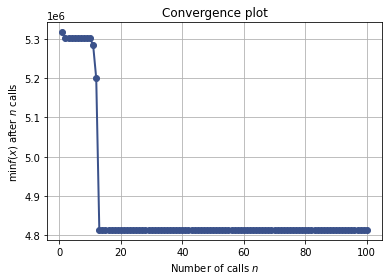

<Figure size 1440x720 with 0 Axes>

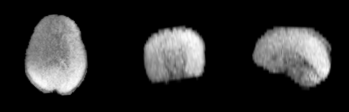

<Figure size 1440x720 with 0 Axes>

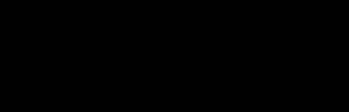

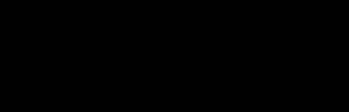

In [15]:
latent_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp.pt').cuda()
def objective(x, latent_train, image_tensor):
    image_tensor = K.enhance.adjust_gamma(image_tensor,x[0])
    image_tensor = K.enhance.adjust_brightness(image_tensor,x[1])
    image_tensor = K.enhance.sharpness(image_tensor,x[2])
    latent_input = kl_forward_latent(model, image_tensor.cuda())
    latent_input = latent_input.flatten().unsqueeze(0)
    latent_train = latent_train.flatten(start_dim=1)
    loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
    return loss.item()
_objective = functools.partial(objective, latent_train=latent_train, image_tensor=image_tensors[0])

res = gp_minimize(_objective,                  # the function to minimize
                  [(1e-6, 2.0),(5e-1,1.),(1e-6,1.)],      # the bounds on each dimension of x
                  n_calls=100,         # the number of evaluations of f
                  noise=0.001,   
                random_state=1234)  # the seed

plot_convergence(res)
image_opti = K.enhance.adjust_gamma(image_tensor,res.x[0])
image_opti = K.enhance.adjust_brightness(image_opti,res.x[1])
image_opti = K.enhance.sharpness(image_opti,res.x[2])
display_multiplanar_center(image_tensors[0][0,0,:,:,:].cpu().numpy())
display_multiplanar_center(image_opti[0,0,:,:,:].cpu().numpy())

# Generating Latents

## Vanilla

In [15]:
latent_brown = []
for img in tqdm(image_tensors):
    img = img.cuda()
    with torch.no_grad():
        latent_brown.append(kl_forward_latent(model,img))
latent_brown = torch.cat(latent_brown,dim=0)
torch.save(latent_brown,'/media/hdd/viscent/SR-UNet/dev/latent_brown.pt')

  0%|          | 0/113 [00:00<?, ?it/s]

## Optimized

In [17]:
def process_and_forward(model, image_tensor, res):
    image_tensor = K.enhance.adjust_gamma(image_tensor,res.x[0])
    image_tensor = K.enhance.adjust_brightness(image_tensor,res.x[1])
    image_tensor = K.enhance.sharpness(image_tensor,res.x[2])
    image_tensor = image_tensor.cuda()
    with torch.no_grad():
        latent = kl_forward_latent(model, image_tensor)
    return latent

latent_brown_opti = []
for img in tqdm(image_tensors):
    latent_brown_opti.append(process_and_forward(model, img, res))
latent_brown_opti = torch.cat(latent_brown_opti,dim=0)
torch.save(latent_brown_opti,'/media/hdd/viscent/SR-UNet/dev/latent_brown_opti.pt')

  0%|          | 0/113 [00:00<?, ?it/s]

<Figure size 1440x720 with 0 Axes>

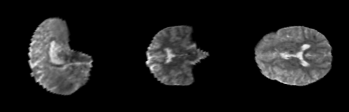

<Figure size 1440x720 with 0 Axes>

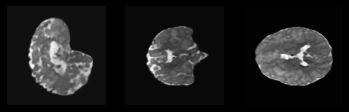

<Figure size 1440x720 with 0 Axes>

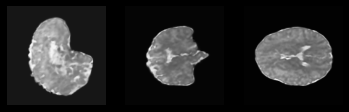

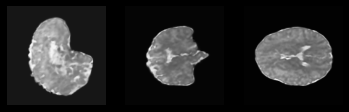

In [18]:
output_opti = model(image_opti.cuda())
output_vanilla = model(image_tensors[0].cuda())
output_opti = output_opti.cpu().detach().numpy()
output_vanilla = output_vanilla.cpu().detach().numpy()
display_multiplanar_center(image_tensors[0][0,0,:,:,:])
display_multiplanar_center(output_opti[0,0,:,:,:])
display_multiplanar_center(output_vanilla[0,0,:,:,:])